In [1]:
import pandas as pd
import numpy as np
import sqlite3
import os.path
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
pd.set_option("display.max_rows",15)
%matplotlib inline

In [2]:
conn = create_engine('sqlite:///../dataset/ijcai_cff_2017.db')

def upload_csv_to_sqlite(file_name, col_names):
    try:
        df = pd.read_sql_query(sql = 'select * from ' + file_name + ' limit 1', con=conn)
        print("Table "+ file_name+" already present")
        return
    except:
        pass
    total_rows = 0
    for df in pd.read_csv('../dataset/'+file_name+'.txt.gz', 
                          compression='gzip', chunksize=5000000, 
                          iterator=True, encoding='utf-8',
                          names=col_names                         
                         ):
        df.to_sql(file_name, conn, if_exists='append',index=False)
        
        total_rows += df.shape[0] 
        print ('For file '+ file_name+' completed {} rows'.format(total_rows))

In [3]:
upload_csv_to_sqlite("shop_info", ("shop_id","city_name",
                                   "location_id", "per_pay",
                                   "score","comment_cnt", "shop_level",
                                   "cate_1_name","cate_2_name","cate_3_name"
                                  ))
upload_csv_to_sqlite("user_view", ("user_id", "shop_id", "time_stamp"))
upload_csv_to_sqlite("user_pay", ("user_id", "shop_id", "time_stamp"))

Table shop_info already present
Table user_view already present
Table user_pay already present


In [4]:
import pickle
def create_sample_pickle(sql_query, pickle_file_name):
    df = pd.read_sql_query(sql=sql_query,con=conn)
    pickle.dump(df, open("../dataset/"+pickle_file_name,"wb"))


In [5]:
pd.read_sql_query("select * from shop_info limit 10", con = conn)

,shop_id,city_name,location_id,per_pay,score,comment_cnt,shop_level,cate_1_name,cate_2_name,cate_3_name
0,1,湖州,885,8,4.0,12.0,2,美食,休闲茶饮,饮品/甜点
1,2,哈尔滨,64,19,NaN,NaN,1,超市便利店,超市,None
2,3,南昌,774,5,3.0,2.0,0,美食,休闲茶饮,奶茶
3,4,天津,380,18,NaN,NaN,1,超市便利店,超市,None
4,5,杭州,263,2,2.0,2.0,0,美食,休闲食品,生鲜水果
5,6,大连,1139,13,3.0,1.0,0,美食,烘焙糕点,面包
6,7,绍兴,145,13,3.0,9.0,2,美食,快餐,西式快餐
7,8,杭州,234,16,3.0,1.0,0,美食,休闲食品,生鲜水果
8,9,杭州,1120,15,4.0,0.0,1,超市便利店,超市,None
9,10,孝感,98,10,NaN,NaN,0,超市便利店,超市,None


In [6]:
pd.read_sql_query("select * from user_view limit 10", con = conn)

,user_id,shop_id,time_stamp
0,13201967,1197,2016-10-21 18:00:00
1,19461365,1197,2016-06-28 23:00:00
2,15022321,1197,2016-07-16 19:00:00
3,5440872,1197,2016-07-15 07:00:00
4,12594529,1197,2016-08-07 16:00:00
5,5440872,1197,2016-08-12 08:00:00
6,19918044,1197,2016-09-03 16:00:00
7,9476039,1197,2016-09-04 17:00:00
8,4081995,1197,2016-09-25 10:00:00
9,12594529,1197,2016-08-07 16:00:00


In [7]:
pd.read_sql_query("select * from user_pay limit 10", con = conn)

,user_id,shop_id,time_stamp
0,22127870,1862,2015-12-25 17:00:00
1,3434231,1862,2016-10-05 11:00:00
2,16955285,1862,2016-02-10 15:00:00
3,13799128,1862,2016-01-13 14:00:00
4,13799128,1862,2016-07-05 12:00:00
5,20244878,1862,2016-09-17 15:00:00
6,20244878,1862,2016-05-29 16:00:00
7,438444,1862,2016-02-22 17:00:00
8,22003193,1862,2016-08-07 15:00:00
9,20244878,1862,2016-04-17 16:00:00


In [8]:
query1 = "select max(shop_id), min(shop_id),\
        avg(shop_id) from shop_info";

In [9]:
pd.read_sql_query(query1, conn)

,max(shop_id),min(shop_id),avg(shop_id)
0,2000,1,1000.5


In [10]:
def create_sample_tables(sample_shop_count = 1):
    
    import random
    sample_shop_ids = [random.randint(0, 2001) 
                       for i in range(0,sample_shop_count)]
    #sample_shop_ids
    #from IPython.core.debugger import Tracer; Tracer()() 
    
    conn.execute("drop table sample_user_pay")
    conn.execute("create table sample_user_pay \
AS select * from user_pay where \
shop_id in " + 
            str(sample_shop_ids)
            .replace("[", "(")
            .replace("]",")"))

    conn.execute("drop table sample_user_view")
    conn.execute("create table sample_user_view \
AS select * from user_view where \
shop_id in " + 
            str(sample_shop_ids)
            .replace("[", "(")
            .replace("]",")"))

    conn.execute("drop table sample_shop_info")
    conn.execute("create table sample_shop_info \
AS select * from shop_info where \
shop_id in " + 
            str(sample_shop_ids)
            .replace("[", "(")
            .replace("]",")"))

    pd.read_sql("select count(*) from sample_user_pay", conn)
    pd.read_sql("select count(*) from sample_user_view", conn)

    pd.read_sql("select count(*) from sample_shop_info", conn)

## Grouping foot traffic on daily basis

In [11]:
def fill_missing_dates(df):
    df.loc[:,"ts"] = pd.to_datetime(df.ts)
    
    #Re-index to fill missing dates
    date_range = pd.date_range(df.ts.min(), df.ts.max())
    df.set_index(['shop_id', 'ts'], inplace = True, drop = True)
    df =  df.reindex(date_range, level = 1)
    return df

def resample_minute_to_daily_and_combine():    
    #def resample_minute_to_daily_and_combine():
    conn.execute("drop table sample_user_view_grouped")
    conn.execute("create table sample_user_view_grouped AS \
    select shop_id, count(*) as total_view, date(time_stamp) as ts \
    from sample_user_view group by shop_id, \
    date(time_stamp)")
    conn.execute("drop table sample_user_pay_grouped")
    conn.execute("create table sample_user_pay_grouped AS \
    select shop_id, count(*) as total_pay, date(time_stamp) as ts \
    from sample_user_pay group by shop_id, \
    date(time_stamp)")

    df_user_view = pd.read_sql_query("select * from sample_user_view_grouped", con = conn)
    df_user_view = fill_missing_dates(df_user_view)
    df_user_pay = pd.read_sql_query("select * from sample_user_pay_grouped", con = conn)
    df_user_pay = fill_missing_dates(df_user_pay)
    return df_user_view, df_user_pay

In [12]:
def prepare_data(shop_id_count = 1, create = False):   
    if create:
        create_sample_tables(shop_id_count)
    df_user_view, df_user_pay = resample_minute_to_daily_and_combine()
    df_shop_ts = pd.concat([df_user_view, df_user_pay], 
                           axis=1)
    df_shop_ts.reset_index().to_sql("train_data", con = conn, if_exists = 'replace', index = False)
    return df_user_view, df_user_pay, df_shop_ts

In [13]:
def aggregate(shop_id):
    df_shop_ts_filtered = df_shop_ts.loc[(shop_id,"2016-07-01"):,:]

    pay_mean = df_shop_ts_filtered.total_pay.mean()
    view_mean = df_shop_ts_filtered.total_view.mean()

    df_shop_ts_filtered = df_shop_ts_filtered.fillna({"total_view":pay_mean, "total_pay":view_mean})

    df_shop_ts_filtered.loc[shop_id,].plot(subplots = True)

    df_shop_ts_filtered.loc[:,"total_today"] = df_shop_ts_filtered.loc[:,"total_pay"] + df_shop_ts_filtered.loc[:,"total_view"]
    df_shop_ts_filtered = df_shop_ts_filtered.drop(["total_view", "total_pay"], axis = 1)
    print(df_shop_ts_filtered)

    print(df_shop_ts_filtered.total_today.describe())
    return df_shop_ts_filtered

In [20]:
def tsa(shop_id):

    df_shop_ts_filtered_single_shop = aggregate(shop_id).loc[shop_id,:]
    
    
    plt.subplot()
    df_shop_ts_filtered_single_shop.total_today.plot(title = "Daily foot traffic")

    from pandas.tools.plotting import lag_plot
    #lag_plot(df_shop_ts_filtered_single_shop.total_today)

    from pandas.tools.plotting import autocorrelation_plot
    fig, axarr = plt.subplots(2,2,figsize=(17,17))
    autocorrelation_plot(df_shop_ts_filtered_single_shop.total_today, ax = axarr[0,0])

    df_shop_ts_filtered_single_shop.rolling(window=14, center=False).mean().plot()
    df_shop_ts_rolling = df_shop_ts_filtered_single_shop.rolling(window=14, center=False)

    df_shop_ts_rolling.min().plot(fig = fig, ax = axarr[1,1])
    df_shop_ts_rolling.max().plot(fig = fig, ax = axarr[1,0])
    axarr[1,0].set_title('Rolling Min - Period 15 days')
    axarr[1,1].set_title('Rolling Max - Period 15 days')

    #df_shop_ts_rolling.quantile(0.25).plot()
    #df_shop_ts_rolling.quantile(0.5).plot(ax = axarr[0,0])
    #df_shop_ts_rolling.quantile(0.75).plot()
    df_shop_ts_rolling.mean().plot(fig = fig, ax = axarr[0,1])
    axarr[0,1].set_title('Rolling Mean plot - Period 15 days')

    try:
        import statsmodels.api as sm
        df_tsa = df_shop_ts_filtered_single_shop.dropna()
        arma_mod_total_today = sm.tsa.ARMA(df_tsa.total_today, order=(2,2))
        arma_res_total_today = arma_mod_total_today.fit(trend='nc', disp=-1)
        print(arma_res_total_today.summary())

        fig, ax = plt.subplots() #figsize=(10,8)
        fig = arma_res_total_today.plot_predict(start='2016-08-01',
                                         end='2016-10-30', 
                                         ax=ax,
                                        dynamic=True
                                        )
        legend = ax.legend(loc='upper left')
    except Exception as e:
        print("***********")
        print (e)
        print("***********")

In [15]:
df_user_view, df_user_pay, df_shop_ts = prepare_data(2000, False)

> <ipython-input-10-59fa1c0e7ca1>(9)create_sample_tables()
      7     from IPython.core.debugger import Tracer; Tracer()()
      8 
----> 9     conn.execute("drop table sample_user_pay")
     10     conn.execute("create table sample_user_pay AS select * from user_pay where shop_id in " + 
     11             str(sample_shop_ids)

ipdb> sample_shop_ids
[1121, 26, 1422, 961, 1279, 1181, 552, 918, 19, 521, 1196, 1333, 188, 1164, 1856, 545, 1485, 1110, 773, 872, 933, 468, 609, 1588, 1038, 1879, 1595, 565, 838, 396, 963, 1983, 1791, 796, 1953, 1334, 92, 802, 412, 918, 1504, 240, 858, 1811, 1405, 55, 1854, 96, 951, 858, 1421, 907, 88, 911, 1135, 1581, 472, 1246, 290, 596, 361, 1682, 1204, 1435, 1199, 717, 1894, 284, 1606, 1577, 199, 944, 1899, 446, 1229, 1223, 1030, 1454, 1876, 12, 1480, 1069, 1230, 896, 913, 310, 1630, 1924, 79, 282, 1798, 915, 1369, 849, 553, 414, 637, 943, 1813, 1612, 1646, 1497, 1258, 1226, 1714, 145, 845, 584, 1142, 1681, 283, 1383, 873, 213, 461, 1932, 828, 174, 1809,

In [17]:
df_user_view

total_view
shop_id ts                    
1       2016-06-22          10
        2016-06-23          18
        2016-06-24           5
        2016-06-25          22
        2016-06-26          15
        2016-06-27          12
        2016-06-28          12
...                        ...
2000    2016-10-25          14
        2016-10-26          13
        2016-10-27          16
        2016-10-28          12
        2016-10-29          11
        2016-10-30           3
        2016-10-31          15

[147722 rows x 1 columns]

In [18]:
df_user_pay

total_pay
shop_id ts                   
1       2015-10-10        188
        2015-10-11        272
        2015-10-12        257
        2015-10-13        239
        2015-10-14        277
        2015-10-15        227
        2015-10-16        242
...                       ...
2000    2016-10-25        181
        2016-10-26        184
        2016-10-27        132
        2016-10-28        133
        2016-10-29         67
        2016-10-30         67
        2016-10-31        168

[376125 rows x 1 columns]

Sample shop id for TSA: 
1633
                    total_today
shop_id ts                     
1633    2016-07-01        115.0
        2016-07-02         98.0
        2016-07-03         91.0
        2016-07-04         91.0
        2016-07-05         83.0
        2016-07-06         88.0
        2016-07-07        106.0
...                         ...
2000    2016-10-25        195.0
        2016-10-26        197.0
        2016-10-27        148.0
        2016-10-28        145.0
        2016-10-29         78.0
        2016-10-30         70.0
        2016-10-31        183.0

[72407 rows x 1 columns]
count    72407.000000
mean       202.058911
std        145.549149
min          2.000000
25%        130.000000
50%        175.000000
75%        232.862297
max       2799.357706
Name: total_today, dtype: float64


/home/ritesh_malaiya/anaconda3/envs/tensorflow/lib/python3.5/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/home/ritesh_malaiya/anaconda3/envs/tensorflow/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ritesh_malaiya/anaconda3/envs/tensorflow/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ritesh_malaiya/anaconda3/envs/tensorflow/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                              ARMA Model Results                              
Dep. Variable:            total_today   No. Observations:                  123
Model:                     ARMA(2, 2)   Log Likelihood                -544.233
Method:                       css-mle   S.D. of innovations             19.809
Date:                Thu, 23 Feb 2017   AIC                           1098.466
Time:                        21:41:03   BIC                           1112.527
Sample:                    07-01-2016   HQIC                          1104.178
                         - 10-31-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.total_today     0.4264        nan        nan        nan         nan         nan
ar.L2.total_today     0.5732        nan        nan        nan         nan         nan
ma.L1.total_today    -0.

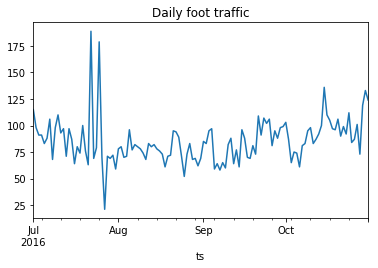

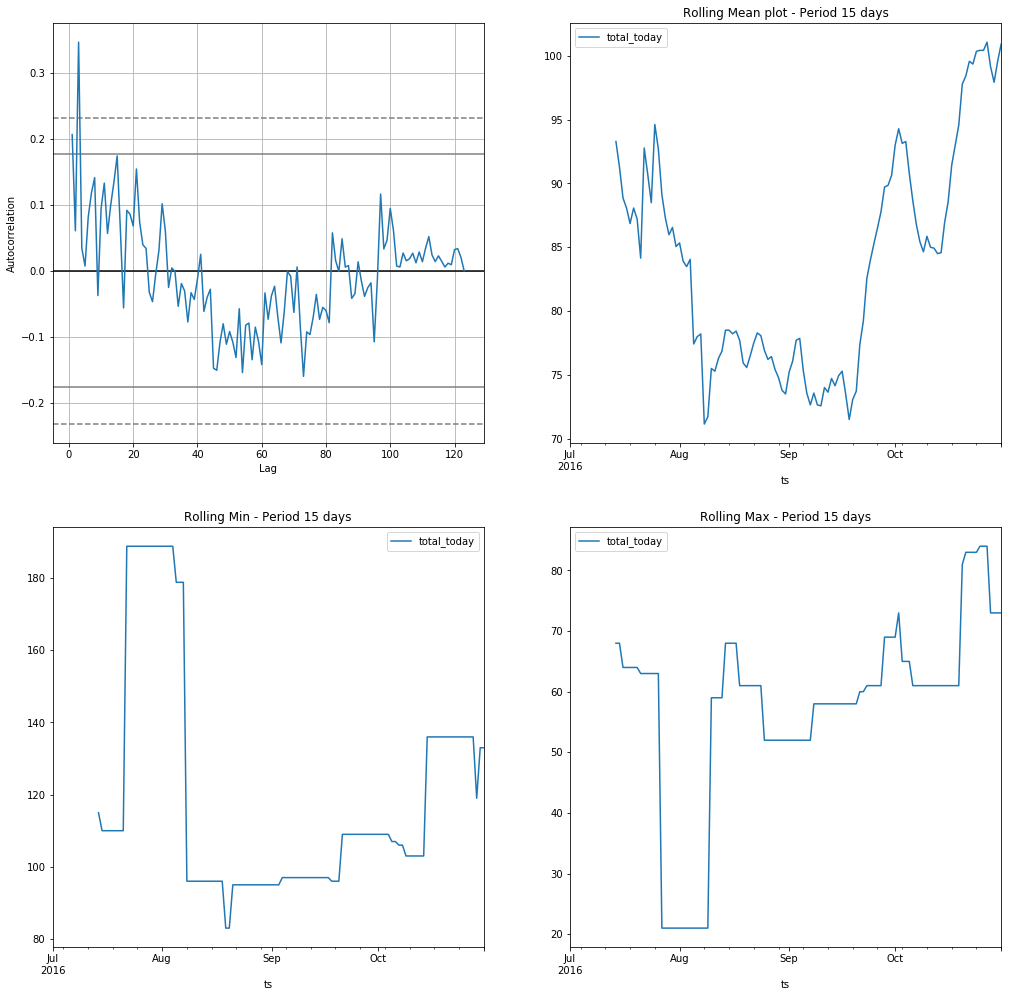

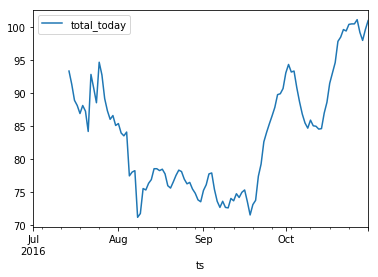

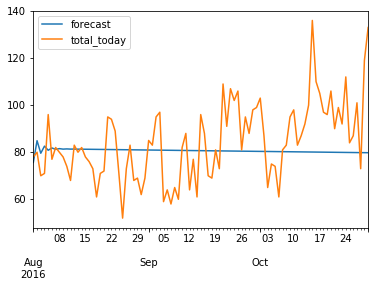

In [25]:
shop_index = df_shop_ts.index.levels[0].get_values()
i = np.random.randint(low = 0, high = len(shop_index), size = 1) #shop_index.get_values()
shop_id = shop_index[i][0]
print("Sample shop id for TSA: " )
print(shop_id)

tsa(shop_id)